# DES Data Set #

In [1]:
from astropy.io import fits
from astropy.table import Table

# === Path to your FITS file ===
fits_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"

# === Open and inspect the HDU list ===
with fits.open(fits_path) as hdul:
    print("🔍 HDU Summary:\n")
    hdul.info()
    
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # Explore each HDU with table data
    for idx, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {idx}: {hdu.name}")
            data = Table(hdu.data)
            print("📋 Columns:", data.colnames)
            print("👀 Preview of first 5 rows:")
            print(data[:5])

🔍 HDU Summary:

Filename: des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_CLEAN    1 BinTableHDU    207   28R x 99C   [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, D, K, D, D]   
  2  DESI_CLEAN    1 BinTableHDU    282   28R x 136C   [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I

In [26]:
from astropy.io import fits
from astropy.table import Table, Column, vstack
import pandas as pd
import numpy as np

# === File paths ===
csv_path = "/Users/pittsburghgraduatestudent/repos/DESI_DES/4_DISTANCES_COVMAT/DES-SN5YR_HD.csv"
fits_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
output_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

# === Load CSV with MU values ===
df_mu = pd.read_csv(csv_path)
df_mu["CID"] = df_mu["CID"].astype(str).str.strip()

# === Load FITS SNIa table ===
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")
snia_ids = snia_table["SNID"].astype(str)

# === Match SNIDs and extract all CSV columns prefixed with CSV_ ===
extra_cols = {f"CSV_{col}": [] for col in df_mu.columns}

for snid in snia_ids:
    snid_str = str(snid).strip()
    match = df_mu[df_mu["CID"] == snid_str]
    
    if not match.empty:
        for col in extra_cols:
            original_col = col.replace("CSV_", "")
            extra_cols[col].append(match.iloc[0][original_col])
    else:
        for col in extra_cols:
            extra_cols[col].append(np.nan)

# === Add CSV columns to SNIa table ===
for colname, values in extra_cols.items():
    snia_table[colname] = Column(values, name=colname)

# === Filter out rows with missing MU ===
finite_mask = np.isfinite(snia_table["CSV_MU"])
filtered_snia_table = snia_table[finite_mask]

# === Load DESI table and apply same filter ===
with fits.open(fits_path) as hdul:
    desi_table = Table(hdul["DESI_CLEAN"].data)
filtered_desi_table = desi_table[finite_mask]

# === Save filtered tables to new FITS ===
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia_table, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi_table, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_path, overwrite=True)

# === Print summary ===
print(f"✅ Retained {len(filtered_snia_table)} out of {len(snia_table)} SNIa with valid MU.")
print(f"✅ Saved filtered + enriched FITS to: {output_path}")

✅ Retained 22 out of 28 SNIa with valid MU.
✅ Saved filtered + enriched FITS to: des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits


In [28]:
from astropy.io import fits
from astropy.table import Table

fits_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

with fits.open(fits_path) as hdul:
    print(f"\nFilename: {fits_path}")
    print(f"{'No.':<6} {'Name':<12} {'Ver':<5} {'Type':<14} {'Cards':<7} {'Dimensions':<12} {'Format'}")
    for i, hdu in enumerate(hdul):
        name = hdu.name
        ver = hdu.header.get('EXTVER', 1)
        hdu_type = hdu.__class__.__name__
        cards = len(hdu.header)
        shape = hdu.data.shape if hdu.data is not None else "()"
        fmt = ""
        if hasattr(hdu, "columns"):
            try:
                fmt_list = [col.format for col in hdu.columns]
                fmt = "[" + ", ".join(fmt_list) + "]"
            except Exception:
                fmt = ""
        print(f"{i:<6} {name:<12} {ver:<5} {hdu_type:<14} {cards:<7} {shape!s:<12} {fmt}")

    # Also print column names for each BinTableHDU
    for i, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {i}: {hdu.name}")
            print("📋 Columns:")
            print(hdu.columns.names)

# === Print SNID, CSV_CID, MU, MUERR_FINAL ===
print("\n🧮 Distance Modulus values from SNIA_CLEAN:")
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")
print(f"{'SNID':<10} {'CSV_CID':<10} {'CSV_MU':<10} {'CSV_MUERR_FINAL'}")
print("-" * 50)
for row in snia_table:
    snid = row["SNID"]
    cid = row["CSV_CID"]
    mu = row["CSV_MU"]
    muerr = row["CSV_MUERR_FINAL"]
    print(f"{str(snid):<10} {str(cid):<10} {mu:<10.4f} {muerr:.4f}")


Filename: des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits
No.    Name         Ver   Type           Cards   Dimensions   Format
0      PRIMARY      1     PrimaryHDU     4       ()           
1      SNIA_CLEAN   1     BinTableHDU    221     (22,)        [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, D, K, D, D, 32A, D, D, D, D, D, D]
2      DESI_CLEAN   1     BinTableHDU    282     (22,)        [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

# Foundation Data Set #

In [2]:
from astropy.io import fits
from astropy.table import Table

# === Path to your FITS file ===
fits_path = "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"

# === Open and inspect the HDU list ===
with fits.open(fits_path) as hdul:
    print("🔍 HDU Summary:\n")
    hdul.info()
    
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # Explore each HDU with table data
    for idx, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {idx}: {hdu.name}")
            data = Table(hdu.data)
            print("📋 Columns:", data.colnames)
            print("👀 Preview of first 5 rows:")
            print(data[:5])

🔍 HDU Summary:

Filename: foundation_desi_matches_d2d_30_delz_0.05_dDLR_5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_CLEAN    1 BinTableHDU    205   46R x 98C   [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, D, D]   
  2  DESI_CLEAN    1 BinTableHDU    282   46R x 136C   [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 

In [29]:
from astropy.io import fits
from astropy.table import Table, Column
import pandas as pd
import numpy as np

# === File paths (update to Foundation-specific) ===
csv_path = "/Users/pittsburghgraduatestudent/repos/DESI_DES/4_DISTANCES_COVMAT/DES-SN5YR_HD.csv"
fits_path = "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
output_path = "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

# === Load CSV with MU values ===
df_mu = pd.read_csv(csv_path)
df_mu["CID"] = df_mu["CID"].astype(str).str.strip()

# === Load FITS SNIa table ===
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")
snia_ids = snia_table["SNID"].astype(str)

# === Match SNIDs and extract all CSV columns prefixed with CSV_ ===
extra_cols = {f"CSV_{col}": [] for col in df_mu.columns}

for snid in snia_ids:
    snid_str = str(snid).strip()
    match = df_mu[df_mu["CID"] == snid_str]
    
    if not match.empty:
        for col in extra_cols:
            original_col = col.replace("CSV_", "")
            extra_cols[col].append(match.iloc[0][original_col])
    else:
        for col in extra_cols:
            extra_cols[col].append(np.nan)

# === Add CSV columns to SNIa table ===
for colname, values in extra_cols.items():
    snia_table[colname] = Column(values, name=colname)

# === Filter out rows with missing MU ===
finite_mask = np.isfinite(snia_table["CSV_MU"])
filtered_snia_table = snia_table[finite_mask]

# === Load DESI table and apply same filter ===
with fits.open(fits_path) as hdul:
    desi_table = Table(hdul["DESI_CLEAN"].data)
filtered_desi_table = desi_table[finite_mask]

# === Save filtered tables to new FITS ===
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia_table, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi_table, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_path, overwrite=True)

# === Print summary ===
print(f"✅ Retained {len(filtered_snia_table)} out of {len(snia_table)} SNIa with valid MU.")
print(f"✅ Saved filtered + enriched FITS to: {output_path}")

✅ Retained 31 out of 46 SNIa with valid MU.
✅ Saved filtered + enriched FITS to: foundation_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits


In [30]:
from astropy.io import fits
from astropy.table import Table

fits_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

with fits.open(fits_path) as hdul:
    print(f"\nFilename: {fits_path}")
    print(f"{'No.':<6} {'Name':<12} {'Ver':<5} {'Type':<14} {'Cards':<7} {'Dimensions':<12} {'Format'}")
    for i, hdu in enumerate(hdul):
        name = hdu.name
        ver = hdu.header.get('EXTVER', 1)
        hdu_type = hdu.__class__.__name__
        cards = len(hdu.header)
        shape = hdu.data.shape if hdu.data is not None else "()"
        fmt = ""
        if hasattr(hdu, "columns"):
            try:
                fmt_list = [col.format for col in hdu.columns]
                fmt = "[" + ", ".join(fmt_list) + "]"
            except Exception:
                fmt = ""
        print(f"{i:<6} {name:<12} {ver:<5} {hdu_type:<14} {cards:<7} {shape!s:<12} {fmt}")

    # Also print column names for each BinTableHDU
    for i, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {i}: {hdu.name}")
            print("📋 Columns:")
            print(hdu.columns.names)

# === Print SNID, CSV_CID, MU, MUERR_FINAL ===
print("\n🧮 Distance Modulus values from SNIA_CLEAN:")
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")
print(f"{'SNID':<10} {'CSV_CID':<10} {'CSV_MU':<10} {'CSV_MUERR_FINAL'}")
print("-" * 50)
for row in snia_table:
    snid = row["SNID"]
    cid = row["CSV_CID"]
    mu = row["CSV_MU"]
    muerr = row["CSV_MUERR_FINAL"]
    print(f"{str(snid):<10} {str(cid):<10} {mu:<10.4f} {muerr:.4f}")


Filename: des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits
No.    Name         Ver   Type           Cards   Dimensions   Format
0      PRIMARY      1     PrimaryHDU     4       ()           
1      SNIA_CLEAN   1     BinTableHDU    221     (22,)        [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, D, K, D, D, 32A, D, D, D, D, D, D]
2      DESI_CLEAN   1     BinTableHDU    282     (22,)        [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

# Low Z Dataset #

In [3]:
from astropy.io import fits
from astropy.table import Table

# === Path to your FITS file ===
fits_path = "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"

# === Open and inspect the HDU list ===
with fits.open(fits_path) as hdul:
    print("🔍 HDU Summary:\n")
    hdul.info()
    
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # Explore each HDU with table data
    for idx, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {idx}: {hdu.name}")
            data = Table(hdu.data)
            print("📋 Columns:", data.colnames)
            print("👀 Preview of first 5 rows:")
            print(data[:5])

🔍 HDU Summary:

Filename: lowz_desi_matches_d2d_30_delz_0.05_dDLR_5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_CLEAN    1 BinTableHDU    507   55R x 249C   [40A, 16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, D, D]   
  

In [31]:
from astropy.io import fits
from astropy.table import Table, Column
import pandas as pd
import numpy as np

# === File paths ===
csv_path = "/Users/pittsburghgraduatestudent/repos/DESI_DES/4_DISTANCES_COVMAT/DES-SN5YR_HD.csv"
fits_path = "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
output_path = "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

# === Load CSV with MU values ===
df_mu = pd.read_csv(csv_path)
df_mu["CID"] = df_mu["CID"].astype(str).str.strip()

# === Load FITS SNIa table ===
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")
snia_ids = snia_table["SNID"].astype(str)

# === Match SNIDs and extract all CSV columns prefixed with CSV_ ===
extra_cols = {f"CSV_{col}": [] for col in df_mu.columns}

for snid in snia_ids:
    snid_str = str(snid).strip()
    match = df_mu[df_mu["CID"] == snid_str]
    
    if not match.empty:
        for col in extra_cols:
            original_col = col.replace("CSV_", "")
            extra_cols[col].append(match.iloc[0][original_col])
    else:
        for col in extra_cols:
            extra_cols[col].append(np.nan)

# === Add CSV columns to SNIa table ===
for colname, values in extra_cols.items():
    snia_table[colname] = Column(values, name=colname)

# === Filter out rows with missing MU ===
finite_mask = np.isfinite(snia_table["CSV_MU"])
filtered_snia_table = snia_table[finite_mask]

# === Load DESI table and apply same filter ===
with fits.open(fits_path) as hdul:
    desi_table = Table(hdul["DESI_CLEAN"].data)
filtered_desi_table = desi_table[finite_mask]

# === Save filtered tables to new FITS ===
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia_table, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi_table, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_path, overwrite=True)

# === Print summary ===
print(f"✅ Retained {len(filtered_snia_table)} out of {len(snia_table)} SNIa with valid MU.")
print(f"✅ Saved filtered + enriched FITS to: {output_path}")

✅ Retained 21 out of 55 SNIa with valid MU.
✅ Saved filtered + enriched FITS to: lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits


In [43]:
from astropy.io import fits
from astropy.table import Table

# Path to the FITS file
fits_path = "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"

# Open the FITS file and summarize structure
with fits.open(fits_path) as hdul:
    print(f"Filename: {fits_path}")
    print(f"{'No.':<6} {'Name':<13} {'Ver':<5} {'Type':<15} {'Cards':<7} {'Dimensions':<12} {'Format'}")
    for i, hdu in enumerate(hdul):
        name = hdu.name
        ver = hdu.header.get('EXTVER', 1)
        hdu_type = hdu.__class__.__name__
        cards = len(hdu.header)
        shape = hdu.data.shape if hdu.data is not None else "()"
        fmt = ""
        if hasattr(hdu, "columns"):
            try:
                fmt_list = [col.format for col in hdu.columns]
                fmt = "[" + ", ".join(fmt_list) + "]"
            except Exception:
                fmt = ""
        print(f"{i:<6} {name:<13} {ver:<5} {hdu_type:<15} {cards:<7} {str(shape):<12} {fmt}")

    # Print column names for each BinTableHDU
    for i, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"\n📁 HDU {i}: {hdu.name}")
            print("📋 Columns:")
            print(hdu.columns.names)

# Read SNIA_CLEAN table
snia_table = Table.read(fits_path, hdu="SNIA_CLEAN")

# Print selected fields
print("\n🧮 Distance Modulus values from SNIA_CLEAN:")
print(f"{'SNID':<10} {'CSV_CID':<10} {'CSV_MU':<10} {'CSV_MUERR_FINAL'}")
print("-" * 50)
for row in snia_table:
    print(f"{str(row['SNID']):<10} {str(row['CSV_CID']):<10} {row['CSV_MU']:<10.4f} {row['CSV_MUERR_FINAL']:.4f}")

Filename: lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits
No.    Name          Ver   Type            Cards   Dimensions   Format
0      PRIMARY       1     PrimaryHDU      4       ()           
1      SNIA_CLEAN    1     BinTableHDU     521     (21,)        [40A, 16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

# Hubble Diagram and Residuals - Using Mykola MWV Training #

In [6]:
from astropy.io import fits
from astropy.table import Table, vstack

# List of FITS files
fits_files = [
    "des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits",
    "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits",
    "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"
]

# Store mini-tables here
tables = []

for file in fits_files:
    snia = Table.read(file, hdu="SNIA_CLEAN")

    # Tag the source
    if "des_desi" in file.lower():
        source = "DES"
    elif "foundation" in file.lower():
        source = "FOUNDATION"
    elif "lowz" in file.lower():
        source = "LOWZ"
    else:
        source = "UNKNOWN"

    # Create new table with selected columns
    mini_table = Table({
        "SNID": snia["SNID"],
        "DESI_HOST_ID": snia["DESI_TARGETID"],
        "CSV_zCMB": snia["CSV_zCMB"],
        "CSV_MU": snia["CSV_MU"],
        "CSV_MUERR_FINAL": snia["CSV_MUERR_FINAL"],
        "CSV_zHD": snia["CSV_zHD"],
        "SOURCE": [source] * len(snia)
    })
    tables.append(mini_table)

# Combine and show result
final_table = vstack(tables)
final_table.pprint(max_lines=-1, max_width=-1)

# Save the combined table to a new FITS file
final_table.write("residuals_data.fits", overwrite=True)
print("✅ Saved combined table to residuals_data.fits")

    SNID       DESI_HOST_ID   CSV_zCMB  CSV_MU CSV_MUERR_FINAL CSV_zHD   SOURCE  
----------- ----------------- -------- ------- --------------- ------- ----------
    1503024 39627628528801157  0.27694  40.925          0.1267 0.27694        DES
    1367571 39627658593567802  0.43311  41.748          0.1427 0.43311        DES
    1298893 39627634547622962  0.19616 39.9524          0.1222 0.19616        DES
    1317277 39627652587323543   0.2371 40.3245          0.1295  0.2371        DES
    1297026 39627658597767657  0.25854 40.5872          0.1179 0.25854        DES
    1305504 39627658601961979  0.49559 42.2792          0.1417 0.49559        DES
    1315192 39627773366508575  0.22714 40.1279          0.1572 0.22714        DES
    1892103 39627634551820861  0.26584 40.7179          0.1783 0.26584        DES
    1913214 39627628537191719  0.31615 41.0804          0.1173 0.31615        DES
    1878148 39627809609484131  0.22454 40.2295          0.1212 0.22453        DES
    1774102 3962

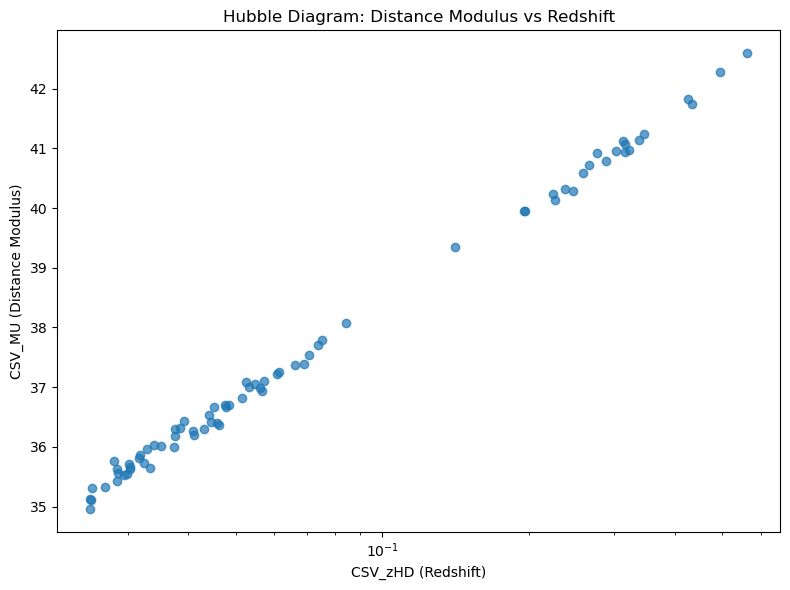

In [9]:
from astropy.table import Table
import matplotlib.pyplot as plt

# Load the FITS file
table = Table.read("residuals_data.fits")

# Extract redshift and distance modulus
z_hd = table["CSV_zHD"]
mu_hd = table["CSV_MU"]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(z_hd, mu_hd, alpha=0.7)
plt.xlabel("CSV_zHD (Redshift)")
plt.ylabel("CSV_MU (Distance Modulus)")
plt.title("Hubble Diagram: Distance Modulus vs Redshift")
plt.xscale("log")
plt.tight_layout()
plt.show()


## Theoretical Fit ##

The luminosity distance $d_L$ in a flat universe where $\Omega_k = 0$ is given by:


$d_L(z) = \frac{c (1 + z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m (1 + z')^3 + \Omega_\Lambda}}$

Plugging this into the $\mu_{\Lambda-CDM}$ equation from Sect 6.1 of Betoule et. al. (2014):

$\mu_{\Lambda \text{CDM}}(z; \Omega_m) = 5 \log_{10}\left(\frac{d_L(z; \Omega_m)}{10 \, \text{pc}}\right)$

Final Formula: 

When $\Omega_\Lambda = 1 - \Omega_m$: 



$\mu_{\Lambda \text{CDM}}(z; \Omega_m) = 5 \log_{10}\left(\frac{\frac{c (1 + z)}{H_0} \int_0^z \frac{1}{\sqrt{\Omega_m (1 + z')^3 + 1 - \Omega_m}} dz' }{10 \, \text{pc}}\right)$



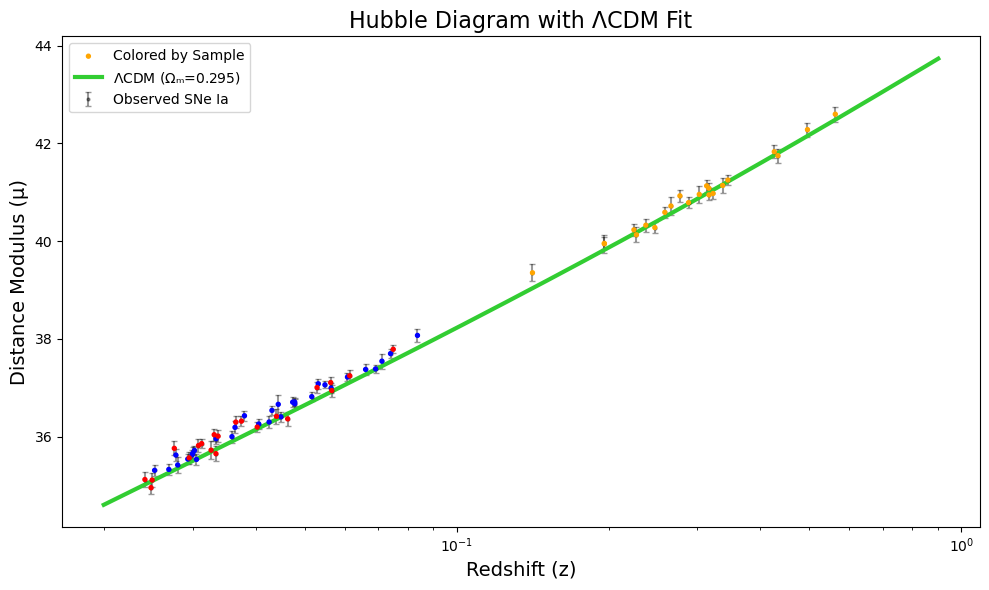

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy.table import Table

# === Load residuals data ===
data = Table.read("residuals_data.fits")
zcmb = np.array(data["CSV_zCMB"])
mu = np.array(data["CSV_MU"])
sigma_mu = np.array(data["CSV_MUERR_FINAL"])

# Optional: Set color by source (DES, LOWZ, FOUNDATION)
source = np.array(data["SOURCE"])
source_str = [s.decode("utf-8") if isinstance(s, bytes) else s for s in source]
source_colors = {"DES": "orange", "FOUNDATION": "blue", "LOWZ": "red"}
set_values = [source_colors[s] for s in source_str]

# === Cosmology Parameters ===
H_o = 73.04  # km/s/Mpc
c = 299792.458   # km/s
Omega_m = 0.295
Omega_Lambda = 1.0 - Omega_m

# === Define Luminosity Distance ===
def integrand(z_prime):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)

def luminosity_distance(z):
    integral, _ = quad(integrand, 0, z)
    d_L = (c / H_o) * (1 + z) * integral  # in Mpc
    return d_L

# === Compute Theoretical μ(z) ===
z_vals = np.linspace(0.02, 0.9, 500)
d_L_vals = np.array([luminosity_distance(z) for z in z_vals])
mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10)  # convert Mpc to pc

# === Plotting ===
plt.figure(figsize=(10, 6))

# Data with error bars
plt.errorbar(
    zcmb, mu, yerr=sigma_mu,
    fmt='o', color='black', label='Observed SNe Ia', capsize=2, markersize=2, alpha=0.4
)

# Color by source
plt.scatter(zcmb, mu, c=set_values, s=8, label='Colored by Sample', zorder=3)

# Theoretical curve
plt.plot(z_vals, mu_theoretical, color='#32CD32', label=r'$\Lambda$CDM (Ωₘ=0.295)', linewidth=3)

# Axes & aesthetics
plt.xscale("log")
plt.xlabel("Redshift (z)", fontsize=14)
plt.ylabel("Distance Modulus (μ)", fontsize=14)
plt.title("Hubble Diagram with ΛCDM Fit", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

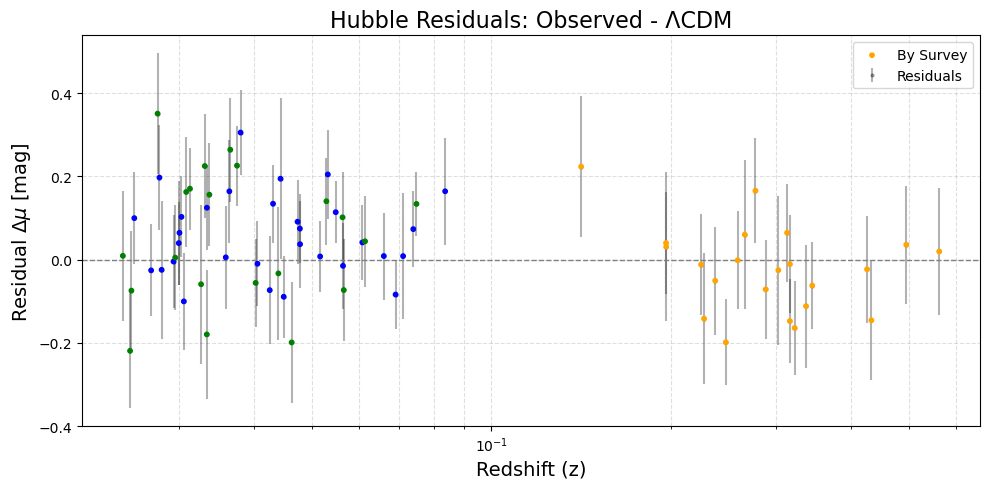

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy.table import Table

# === Load data ===
data = Table.read("residuals_data.fits")
zcmb = np.array(data["CSV_zCMB"])
mu_obs = np.array(data["CSV_MU"])
muerr = np.array(data["CSV_MUERR_FINAL"])

# Decode survey source if needed
source = np.array([s.decode() if isinstance(s, bytes) else s for s in data["SOURCE"]])
source_colors = {"DES": "orange", "FOUNDATION": "blue", "LOWZ": "green"}
color_vals = [source_colors.get(s, "gray") for s in source]

# === Cosmology Parameters ===
H_o = 70  # km/s/Mpc
c = 3e5   # km/s
Omega_m = 0.295
Omega_Lambda = 1.0 - Omega_m

# === Define luminosity distance ===
def integrand(z_prime):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)

def luminosity_distance(z):
    integral, _ = quad(integrand, 0, z)
    return (c / H_o) * (1 + z) * integral  # in Mpc

# === Compute theoretical distance modulus at each z ===
mu_model = []
for z in zcmb:
    d_L = luminosity_distance(z)
    mu = 5 * np.log10(d_L * 1e6 / 10)  # convert Mpc to pc
    mu_model.append(mu)
mu_model = np.array(mu_model)

# === Compute residuals ===
residuals = mu_obs - mu_model

# === Plot residuals ===
plt.figure(figsize=(10, 5))

# Residuals with error bars
plt.errorbar(zcmb, residuals, yerr=muerr, fmt='o', color='black', alpha=0.3, markersize=2, label='Residuals')

# Scatter colored by sample
plt.scatter(zcmb, residuals, c=color_vals, s=10, label='By Survey', zorder=3)

# Horizontal line at 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Aesthetics
plt.xscale("log")
plt.xlabel("Redshift (z)", fontsize=14)
plt.ylabel(r"Residual $\Delta \mu$ [mag]", fontsize=14)
plt.title("Hubble Residuals: Observed - ΛCDM", fontsize=16)
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.integrate import quad
from astropy.table import Table, Column

# === Load the original data ===
data = Table.read("residuals_data.fits")
zcmb = np.array(data["CSV_zCMB"])
mu_obs = np.array(data["CSV_MU"])

# === Cosmology parameters ===
H_o = 70  # km/s/Mpc
c = 3e5   # km/s
Omega_m = 0.295
Omega_Lambda = 1.0 - Omega_m

# === Define luminosity distance ===
def integrand(z_prime):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)

def luminosity_distance(z):
    integral, _ = quad(integrand, 0, z)
    return (c / H_o) * (1 + z) * integral  # in Mpc

# === Compute model mu and residuals ===
mu_model = np.array([5 * np.log10(luminosity_distance(z) * 1e6 / 10) for z in zcmb])
residuals = mu_obs - mu_model

# === Add residuals as new column ===
data["RESID"] = Column(residuals, name="RESID")

# === Save to new FITS file ===
data.write("residuals.fits", overwrite=True)

print("✅ Created file: residuals.fits with RESID column added.")

✅ Created file: residuals.fits with RESID column added.


In [71]:
from astropy.table import Table

# Load the residuals file
residuals_table = Table.read("residuals.fits")

# Print all column names
print("📋 Columns in residuals.fits:")
print(residuals_table.colnames)

# Print all values from each column
print("\n📄 Full Data:")
residuals_table.pprint(max_lines=-1, max_width=-1)
print(f"\n📏 Number of rows in residuals.fits: {len(residuals_table)}")

📋 Columns in residuals.fits:
['SNID', 'DESI_HOST_ID', 'CSV_zCMB', 'CSV_MU', 'CSV_MUERR_FINAL', 'SOURCE', 'RESID']

📄 Full Data:
    SNID       DESI_HOST_ID   CSV_zCMB  CSV_MU CSV_MUERR_FINAL   SOURCE           RESID         
----------- ----------------- -------- ------- --------------- ---------- ----------------------
    1503024 39627628528801157  0.27694  40.925          0.1267        DES     0.1655253090522919
    1367571 39627658593567802  0.43311  41.748          0.1427        DES   -0.14574454363769007
    1298893 39627634547622962  0.19616 39.9524          0.1222        DES    0.04002105421893276
    1317277 39627652587323543   0.2371 40.3245          0.1295        DES   -0.05057616413026267
    1297026 39627658597767657  0.25854 40.5872          0.1179        DES -0.0015251916259018117
    1305504 39627658601961979  0.49559 42.2792          0.1417        DES   0.035840644676163436
    1315192 39627773366508575  0.22714 40.1279          0.1572        DES   -0.14181250405303558

# Using Astropy.cosmology for the Cosmological Fit #

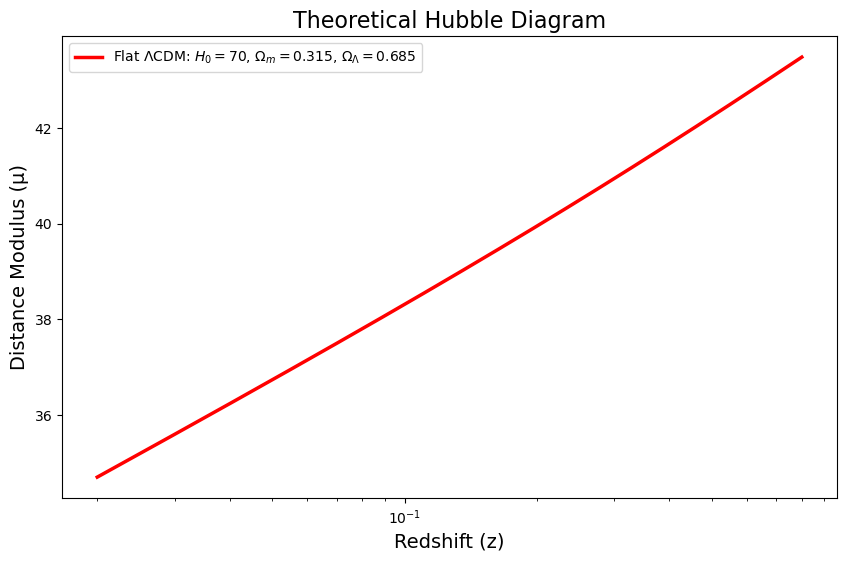

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# === Define the cosmological model ===
H0 = 70
Om0 = 0.315
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# === Derived parameters ===
Omega_lambda = 1 - Om0
Omega_k = 0.0  # Flat universe by definition

# === Generate redshift values ===
z_vals = np.linspace(0.02, 0.8, 500)

# === Compute the distance modulus (mu) ===
mu_theoretical = cosmo.distmod(z_vals).value  # in magnitudes

# === Plot the Hubble diagram ===
plt.figure(figsize=(10, 6))
plt.plot(z_vals, mu_theoretical, 'r-', label=fr'Flat $\Lambda$CDM: $H_0={H0}$, $\Omega_m={Om0}$, $\Omega_\Lambda={1 - Om0}$', linewidth=2.5)
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus (μ)', fontsize=14)
plt.title('Theoretical Hubble Diagram', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

In [2]:
from astropy.io import fits
from astropy.table import Table, vstack

# List of FITS files
fits_files = [
    "des_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits",
    "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits",
    "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5_with_mu_filtered.fits"
]

# Store mini-tables here
tables = []

for file in fits_files:
    snia = Table.read(file, hdu="SNIA_CLEAN")

    # Tag the source
    if "des_desi" in file.lower():
        source = "DES"
    elif "foundation" in file.lower():
        source = "FOUNDATION"
    elif "lowz" in file.lower():
        source = "LOWZ"
    else:
        source = "UNKNOWN"

    # Create new table with selected columns
    mini_table = Table({
        "SNID": snia["SNID"],
        "DESI_HOST_ID": snia["DESI_TARGETID"],
        "CSV_zCMB": snia["CSV_zCMB"],
        "CSV_MU": snia["CSV_MU"],
        "CSV_MUERR_FINAL": snia["CSV_MUERR_FINAL"],
        "CSV_zHD": snia["CSV_zHD"],
        "SOURCE": [source] * len(snia)
    })
    tables.append(mini_table)

# Combine and show result
final_table = vstack(tables)
final_table.pprint(max_lines=-1, max_width=-1)

# Save the combined table to a new FITS file
final_table.write("residuals_data.fits", overwrite=True)
print("✅ Saved combined table to residuals_data.fits")

    SNID       DESI_HOST_ID   CSV_zCMB  CSV_MU CSV_MUERR_FINAL CSV_zHD   SOURCE  
----------- ----------------- -------- ------- --------------- ------- ----------
    1503024 39627628528801157  0.27694  40.925          0.1267 0.27694        DES
    1367571 39627658593567802  0.43311  41.748          0.1427 0.43311        DES
    1298893 39627634547622962  0.19616 39.9524          0.1222 0.19616        DES
    1317277 39627652587323543   0.2371 40.3245          0.1295  0.2371        DES
    1297026 39627658597767657  0.25854 40.5872          0.1179 0.25854        DES
    1305504 39627658601961979  0.49559 42.2792          0.1417 0.49559        DES
    1315192 39627773366508575  0.22714 40.1279          0.1572 0.22714        DES
    1892103 39627634551820861  0.26584 40.7179          0.1783 0.26584        DES
    1913214 39627628537191719  0.31615 41.0804          0.1173 0.31615        DES
    1878148 39627809609484131  0.22454 40.2295          0.1212 0.22453        DES
    1774102 3962

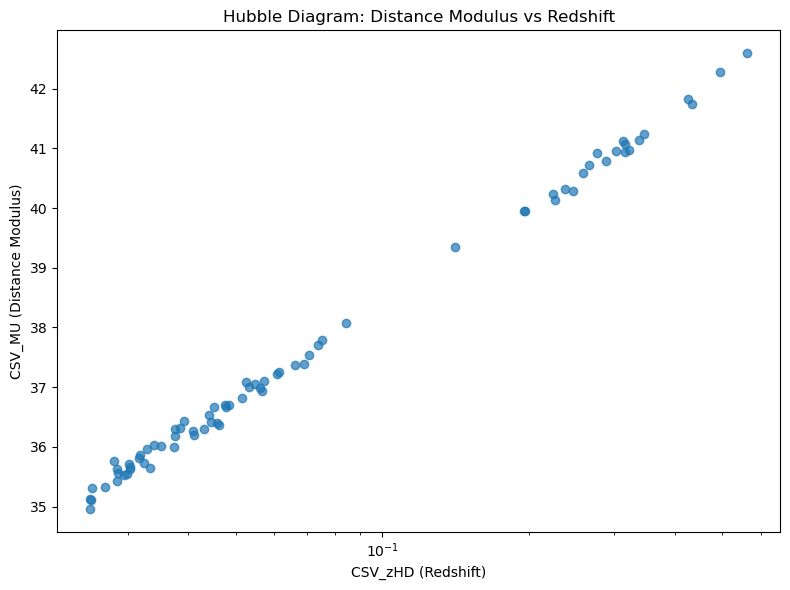

In [11]:
from astropy.table import Table
import matplotlib.pyplot as plt

# Load the FITS file
table = Table.read("residuals_data.fits")

# Extract redshift and distance modulus
z_hd = table["CSV_zHD"]
mu_hd = table["CSV_MU"]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(z_hd, mu_hd, alpha=0.7)
plt.xlabel("CSV_zHD (Redshift)")
plt.ylabel("CSV_MU (Distance Modulus)")
plt.title("Hubble Diagram: Distance Modulus vs Redshift")
plt.xscale("log")
plt.tight_layout()
plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_31830/997110390.py:43: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Distance Modulus $\mu$", fontsize=14)


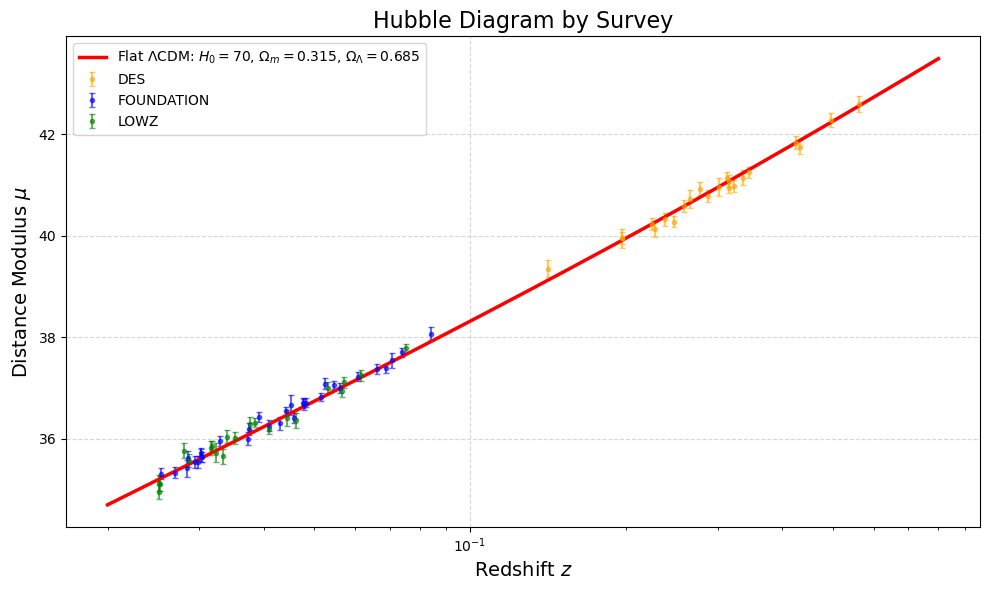

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# === Load the FITS file ===
data = Table.read("residuals_data.fits")

# === Extract columns and decode SOURCE ===
z = np.array(data["CSV_zHD"])
mu = np.array(data["CSV_MU"])
mu_err = np.array(data["CSV_MUERR_FINAL"])
source = np.array([s.decode("utf-8") if isinstance(s, bytes) else s for s in data["SOURCE"]])

# === Begin plotting ===
plt.figure(figsize=(10, 6))

# Plot DES
mask_des = source == "DES"
plt.errorbar(
    z[mask_des], mu[mask_des], yerr=mu_err[mask_des],
    fmt='o', color='orange', markersize=3, capsize=2, alpha=0.6, label='DES'
)

# Plot FOUNDATION
mask_foundation = source == "FOUNDATION"
plt.errorbar(
    z[mask_foundation], mu[mask_foundation], yerr=mu_err[mask_foundation],
    fmt='o', color='blue', markersize=3, capsize=2, alpha=0.6, label='FOUNDATION'
)

# Plot LOWZ
mask_lowz = source == "LOWZ"
plt.errorbar(
    z[mask_lowz], mu[mask_lowz], yerr=mu_err[mask_lowz],
    fmt='o', color='green', markersize=3, capsize=2, alpha=0.6, label='LOWZ'
)

# === Theory Plot ===

plt.plot(z_vals, mu_theoretical, 'r-', label=fr'Flat $\Lambda$CDM: $H_0={H0}$, $\Omega_m={Om0}$, $\Omega_\Lambda={1 - Om0}$', linewidth=2.5)

plt.xlabel("Redshift $z$", fontsize=14)
plt.ylabel("Distance Modulus $\mu$", fontsize=14)
plt.title("Hubble Diagram by Survey", fontsize=16)
plt.xscale("log")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

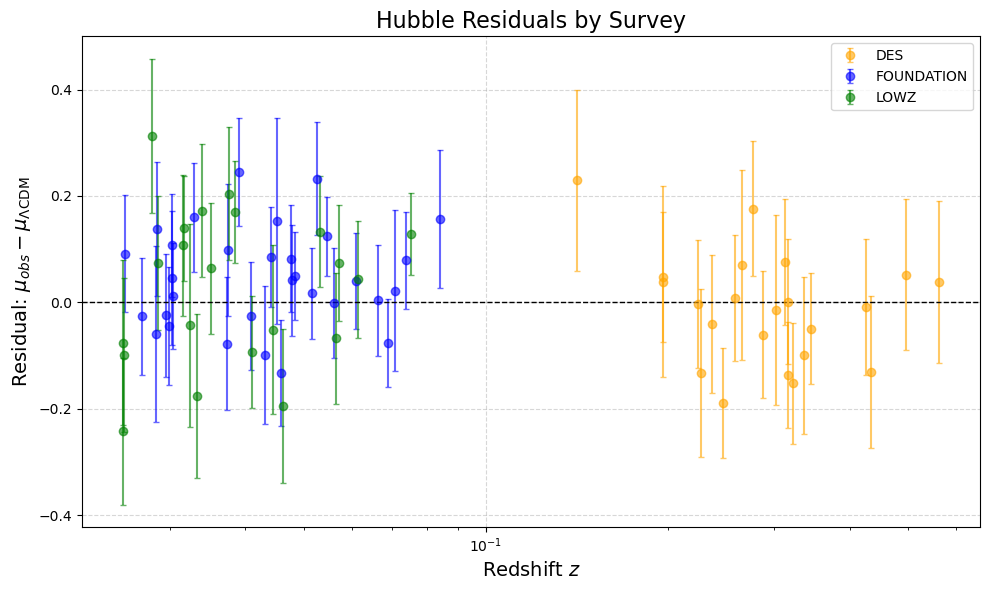

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

# === Cosmology parameters ===
H0 = 70
Om0 = 0.315
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# === Load the FITS data ===
data = Table.read("residuals_data.fits")

# === Extract columns ===
z = np.array(data["CSV_zHD"])
mu_obs = np.array(data["CSV_MU"])
mu_err = np.array(data["CSV_MUERR_FINAL"])
source = np.array([s.decode("utf-8") if isinstance(s, bytes) else s for s in data["SOURCE"]])

# === Compute theoretical mu ===
mu_theory = cosmo.distmod(z).value

# === Compute residuals ===
residuals = mu_obs - mu_theory

# === Plot residuals by source ===
plt.figure(figsize=(10, 6))

# Plot DES
mask_des = source == "DES"
plt.errorbar(z[mask_des], residuals[mask_des], yerr=mu_err[mask_des], fmt='o', color='orange', label="DES", alpha=0.6, capsize=2)

# Plot FOUNDATION
mask_foundation = source == "FOUNDATION"
plt.errorbar(z[mask_foundation], residuals[mask_foundation], yerr=mu_err[mask_foundation], fmt='o', color='blue', label="FOUNDATION", alpha=0.6, capsize=2)

# Plot LOWZ
mask_lowz = source == "LOWZ"
plt.errorbar(z[mask_lowz], residuals[mask_lowz], yerr=mu_err[mask_lowz], fmt='o', color='green', label="LOWZ", alpha=0.6, capsize=2)

# === Plot formatting ===
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Redshift $z$", fontsize=14)
plt.ylabel("Residual: $\\mu_{obs} - \\mu_{\\Lambda\\mathrm{CDM}}$", fontsize=14)
plt.title("Hubble Residuals by Survey", fontsize=16)
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
data["RESIDUAL"] = residuals
data.write("residuals_v2.fits", overwrite=True)

In [24]:
from astropy.table import Table

# Load the FITS file
data = Table.read("residuals_v2.fits")

# Print all rows and columns
data.pprint(max_lines=-1, max_width=-1)


    SNID       DESI_HOST_ID   CSV_zCMB  CSV_MU CSV_MUERR_FINAL CSV_zHD   SOURCE          RESIDUAL       
----------- ----------------- -------- ------- --------------- ------- ---------- ----------------------
    1503024 39627628528801157  0.27694  40.925          0.1267 0.27694        DES    0.17577328550434146
    1367571 39627658593567802  0.43311  41.748          0.1427 0.43311        DES   -0.13103704142523043
    1298893 39627634547622962  0.19616 39.9524          0.1222 0.19616        DES    0.04780427097890083
    1317277 39627652587323543   0.2371 40.3245          0.1295  0.2371        DES  -0.041531900450607395
    1297026 39627658597767657  0.25854 40.5872          0.1179 0.25854        DES   0.008169876931397368
    1305504 39627658601961979  0.49559 42.2792          0.1417 0.49559        DES    0.05220545899071283
    1315192 39627773366508575  0.22714 40.1279          0.1572 0.22714        DES   -0.13307287925478306
    1892103 39627634551820861  0.26584 40.7179         